## **CSE 5520 - Homework 8: Visualization of GMM and EM**

This homework is to help you practice with some data visualization fundamentals. You are
expected to use these visualization techniques and others in your final project. You are required
to do this exercise in Python. All plots/graphs must have titles and x-y coordinate tick labels.

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from statsmodels.stats.multitest import multipletests

In [7]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [8]:
START_DATE = "2009-10-27" # First day filtering
END_DATE = "2019-10-22" # Last day filtering

# Teams in NBA based on dataset
WESTERN_CONFERENCE_TEAMS = ['Portland Trail Blazers', 'Los Angeles Lakers', 'Dallas Mavericks', 'Golden State Warriors', 'Denver Nuggets',
                            'Los Angeles Clippers', 'San Antonio Spurs', 'Minnesota Timberwolves', 'Memphis Grizzlies', 'New Orleans Hornets',
                            'Phoenix Suns', 'Oklahoma City Thunder', 'Utah Jazz', 'Houston Rockets', 'Sacramento Kings', 'LA Clippers', 'New Orleans Pelicans']

EASTERN_CONFERENCE_TEAMS = ['Cleveland Cavaliers', 'Atlanta Hawks', 'Miami Heat', 'Boston Celtics',  'Orlando Magic', 'Toronto Raptors',
                            'Chicago Bulls', 'New Jersey Nets', 'Detroit Pistons', 'Charlotte Bobcats', 'Philadelphia 76ers', 'Indiana Pacers', 
                            'Washington Wizards', 'New York Knicks', 'Milwaukee Bucks', 'Brooklyn Nets', 'Charlotte Hornets']
ALL_NBA_TEAMS = WESTERN_CONFERENCE_TEAMS + EASTERN_CONFERENCE_TEAMS
METRICS = ['pts_home', 'fg_pct_home', 'fg3_pct_home', 'ft_pct_home', 'reb_home', 'ast_home', 'stl_home', 'blk_home', 'tov_home']

#   Create DataFrame for summary and filter data
summary_df = pd.read_csv("game.csv")
summary_df['game_date'] = pd.to_datetime(summary_df['game_date'])
range_dataframe = summary_df[(summary_df['game_date'] >= START_DATE) & (summary_df['game_date'] < END_DATE)]
range_dataframe = range_dataframe[range_dataframe['team_name_home'].isin(ALL_NBA_TEAMS)]

## **Part 1: K-means and GMM**

This part is to help your term project by gently introducing visualization of k-means vs GMM clustering methods. You will use your own data related to your term project.

**Step 1.** Plot your 2D data (scatter plot). Determine the number of clusters k
**(extra credit)** You can use silhouette method or elbow method to find the optimum k.

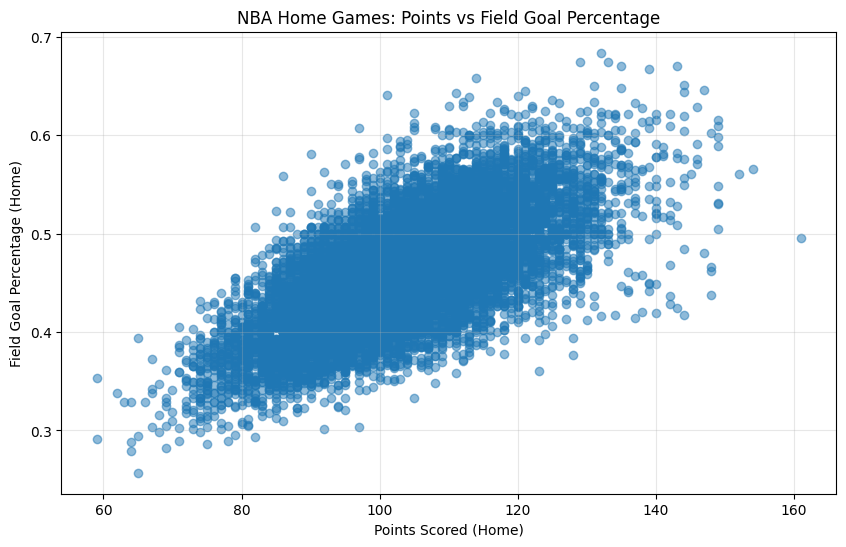

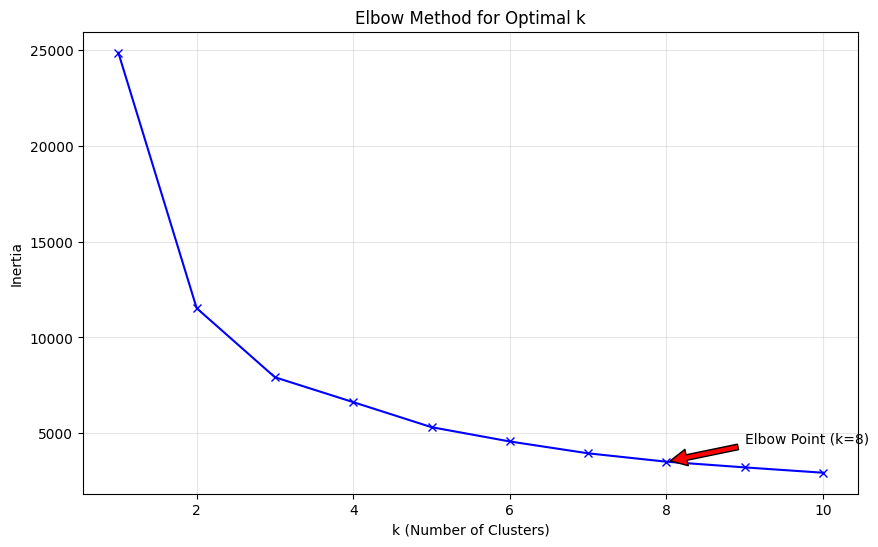

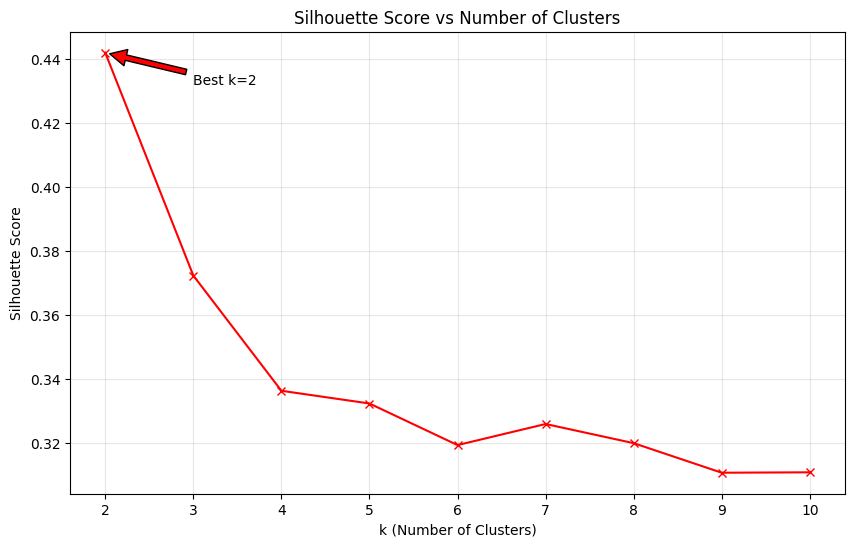

Based on the elbow method, the optimal number of clusters appears to be 8
Based on silhouette analysis, the optimal number of clusters is 2

Cluster size distribution:
Cluster 0: 1360 samples
Cluster 1: 1645 samples
Cluster 2: 1977 samples
Cluster 3: 1779 samples
Cluster 4: 1751 samples
Cluster 5: 2155 samples
Cluster 6: 866 samples
Cluster 7: 899 samples


In [11]:
X = range_dataframe[['pts_home', 'fg_pct_home']].dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 1. Create scatter plot of original data
plt.figure(figsize=(10, 6))
plt.scatter(X['pts_home'], X['fg_pct_home'], alpha=0.5)
plt.title('NBA Home Games: Points vs Field Goal Percentage')
plt.xlabel('Points Scored (Home)')
plt.ylabel('Field Goal Percentage (Home)')
plt.grid(True, alpha=0.3)
plt.show()

inertias = []
K = range(1, 11)  # Testing k from 1 to 10

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K, inertias, 'bx-')
plt.xlabel('k (Number of Clusters)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True, alpha=0.3)


# Add elbow point annotation
# Calculate the angle of the elbow
angles = []
for i in range(1, len(inertias)-1):
    v1 = [1, inertias[i] - inertias[i-1]]
    v2 = [1, inertias[i+1] - inertias[i]]
    angle = np.abs(np.arctan2(v1[1], v1[0]) - np.arctan2(v2[1], v2[0]))
    angles.append(angle)

elbow_point = np.argmax(angles) + 2  # Add 2 because we started from k=1
plt.annotate(f'Elbow Point (k={elbow_point})',
            xy=(elbow_point, inertias[elbow_point-1]),
            xytext=(elbow_point+1, inertias[elbow_point-1]+1000),
            arrowprops=dict(facecolor='red', shrink=0.05))
plt.show()

# 3. Calculate silhouette scores
from sklearn.metrics import silhouette_score

silhouette_scores = []
K = range(2, 11)  # Silhouette score needs at least 2 clusters

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(K, silhouette_scores, 'rx-')
plt.xlabel('k (Number of Clusters)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.grid(True, alpha=0.3)

# Add best k annotation
best_k = K[np.argmax(silhouette_scores)]
plt.annotate(f'Best k={best_k}',
            xy=(best_k, max(silhouette_scores)),
            xytext=(best_k+1, max(silhouette_scores)-0.01),
            arrowprops=dict(facecolor='red', shrink=0.05))
plt.show()

print(f"Based on the elbow method, the optimal number of clusters appears to be {elbow_point}")
print(f"Based on silhouette analysis, the optimal number of clusters is {best_k}")

# Print cluster size distribution for the recommended number of clusters
kmeans_optimal = KMeans(n_clusters=elbow_point, random_state=42)
cluster_labels = kmeans_optimal.fit_predict(X_scaled)
cluster_sizes = pd.Series(cluster_labels).value_counts().sort_index()
print("\nCluster size distribution:")
for cluster, size in cluster_sizes.items():
    print(f"Cluster {cluster}: {size} samples")

**Step 2.** With your chosen number of clusters k, find the k-means clustering your data. Plot
clustering result with different colors. For example, cluster 1 in red, cluster 2 in blue, etc. You
can repeat with different k to find the better number of clusters.

In [ ]:
# Determine the optimal number of clusters
optimal_k_elbow, optimal_k_silhouette, optimal_k_gap = determine_optimal_clusters(X_scaled)
optimal_k = int(np.median([optimal_k_elbow, optimal_k_silhouette, optimal_k_gap]))
print(f"Recommended number of clusters: {optimal_k}")

# Perform K-Means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# Plot the clustering results
plt.figure(figsize=(10, 6))
plt.scatter(X['pts_home'], X['fg_pct_home'], c=cluster_labels, cmap='viridis', alpha=0.6)
plt.xlabel('Points Scored (Home)')
plt.ylabel('Field Goal Percentage (Home)')
plt.title(f'K-Means Clustering (k={optimal_k})')
plt.colorbar(label='Cluster')
plt.grid(True, alpha=0.3)
plt.show()

# Visualize cluster centroids
centroids = kmeans.cluster_centers_
plt.figure(figsize=(10, 6))
plt.scatter(X['pts_home'], X['fg_pct_home'], c=cluster_labels, cmap='viridis', alpha=0.6)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=200, c='red', label='Centroids')
plt.xlabel('Points Scored (Home)')
plt.ylabel('Field Goal Percentage (Home)')
plt.title(f'K-Means Clustering Centroids (k={optimal_k})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**Step 3.** Calculate the centroid (mean of x axis, mean of y axis) of each cluster and radii that covers 90 % of data of the cluster. 

**Step 4.** Plot the circles centered at the centroid with radius calculated in step 3 on top of the plot
from step 2. Mark the centroid with ‘X’.

**Step 5.** In a markdown cell, discuss the best k

**Step 6.** Repeat steps 2 ~ 5, using GMM with EM clustering method. In this case, calculate covariance matrix for each cluster instead of radius. Show the values.

**Step 7.** Discuss which clustering method is better for your data in a markdown cell.

**Step 8. (extra credit)** Plot 2D Gaussian curve calculated in step 6 as shown in the 2D GMM with EM examples in the lecture slides.

### **Part 2: DASH**

This part is to continuously help you do the term project by making you include visualization of k-means and GMM clustering methods in your Dashboard.

**Step 1.** Publish the visualizations you have done in Part 1 to your Dashboard.

**Step 2.** Take a screenshot (screen clip) of your Dashboard and include it in a markdown cell so that you succeeded in publishing your Part I plots in your Dashboard publication. 